# Chapter 15: Autoencoders

## Chapter Exercises

### 1. What are the main tasks that autoencoders are used for?

Autoencoders are neural networks which are trained to reproduce their output. Rheir hidden layers have a lower dimensionality than the signals, so the model needs to learn a "coding" of the training set in the hidden layers. From these codings it should be possible to reproduce instances of the input set, or event create entirely new instances that appear to be sampled from the original training set.

### 2. Suppose you want to train a classifier and have plenty of unlabeled training data, but only a few thousand labeled instances. How could autoencoders help? How would you proceed?

First you would train an autoencoder to reproduce the unlabeled training data. The lower layers and coding layer can be reused as the lower layers of a classification neural network. The classifier will be able to get reasonable performance because of the unsupervised pretraining you did with the autoencoder.

### 3. If an autoencoder perfectly reconstructs the inputs, is it necessarily a good autoencoder? How can you evaluate the performance of the autoencoder?

Not necessarily. The model could have just learned to reproduce the training set and cannot generalize to new data, i.e. it is overfitting the training data. One way to see if an autoencoder can generalize is to record the value of the cost function when trying to reproduce new data from the test set.

### 4. What are undercomplete and overcomplete autoencoders? What is the main risk of an excessive undercomplete autoencoder? What about the main risk of an overcomplete autoencoder?

An undercomplete autoencoder's coding layer has a lower dimensionality than the input features. This forces the model to learn general patterns about the training set since it must learn to represent the information in a more dense representation.

An overcomplete autoencoder's coding layer has a higher dimensionality than the input features. This means it is capable of trivially reproducing the input features because it has more degrees of freedom than the input. This is why we enforce sparsity loss on overcomplete autoencoders, to prevent overfitting.

### 5. How would you tie weights in a stacked autoencoder? What is the point of doing so?

If you have a stacked autoencoder with $N$ hidden layers, let $W_L$ be the weights (or kernel) of the $L$<sup>th</sup> layer. You tie the weights of an autoencoder by setting

$$ W_{N - L + 1} = W_L^{\;T} $$

for each $L$ up to $N/2$. You can see an example of an autoencoder that ties weights in `Autoencoders.ipynb`.

### 6. What is a common technique to visualize features learned by the lower layer of a stacked autoencoder? What about the higher layers?

One way to visualize the lower layer features is to reshape the weight vectors of the coding layers to the shape of the input features and plot them, see **Visualizing the Extracted Features** in `Autoencoders.ipynb` for an example. 

To visualize the features you can see which training instances activate each neuron in the higher layers the most.

### 7. What is a generative model? Can you name a type of generative autoencoder?

A generative model are probabilistic models whose outputs depend on change, both during training and during producing (or "generating") new data that looks like it was sampled from the training set. The model also learns the parameters for the distribution of the random variables as part of training.

One type of generative autoencoder is a _variational autoencoder_, see `Autoencoders.ipynb` for an example of a variational autoencoder for the MNIST dataset.

### 8. Let's use a denoising autoencoder to pretrain an image classifier.

#### You can use MNIST (simplest), or another large set of images such as [CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) if you want a bigger challenge. If you choose CIFAR10 you need to write code to load batches of images for traiing. If you want to skip this part, [TensorFlow's model zoo contains tools to do just that](https://github.com/tensorflow/models/blob/master/research/slim/download_and_convert_data.py).

Since the MNIST dataset is used many places in this repository, I am going to use the CIFAR10 dataset and train a convolutional autoencoder since the final task is to train an image classifcation model.

In [0]:
# Downloading the data. The code here is based on the code from
# https://github.com/tensorflow/models/blob/master/research/slim/datasets/download_and_convert_cifar10.py

from six.moves import urllib
import os
import sys
import tarfile

!mkdir -p 'data'
data_dir = 'data/'

data_url = 'https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz'
filename = data_url.split('/')[-1]
filepath = data_dir + data_url.split('/')[-1]

if not os.path.exists(filepath):
  def progress(count, block_size, total_size):
    sys.stdout.write('\r>> Downloading %s %.1f%%' % \
        (filename, float(count * block_size) / total_size * 100))
    sys.stdout.flush()
  filepath, _ = urllib.request.urlretrieve(data_url, filepath, progress)
  tarfile.open(filepath, 'r:gz').extractall(data_dir)

>> Downloading cifar-10-python.tar.gz 100.0%

In [0]:
!ls data/cifar-10-batches-py/

batches.meta  data_batch_2  data_batch_4  readme.html
data_batch_1  data_batch_3  data_batch_5  test_batch


In [0]:
# Transforming the data into a useable form.

import pickle
import numpy as np

cifar_dir = 'data/cifar-10-batches-py/'
batches_path = cifar_dir + 'data_batch_'
test_batch_path = cifar_dir + 'test_batch'

data_batches = []
X_train, y_train = [], []
for i in range(1, 6):
  with open(batches_path + str(i), 'rb') as f:
    D = pickle.load(f, encoding='bytes')
    for data in D[b'data']:
      X_train.append(data / 255)
    for label in D[b'labels']:
      y_train.append(label)

X_test, y_test = [], []
with open(test_batch_path, 'rb') as f:
  D = pickle.load(f, encoding='bytes')
  for data in D[b'data']:
    X_test.append(data / 255)
  for label in D[b'labels']:
    y_test.append(label)

In [0]:
X_train, y_train = \
    np.array(X_train, dtype=np.float32), np.array(y_train, dtype=np.int32)
X_test, y_test = \
    np.array(X_test, dtype=np.float32), np.array(y_test, dtype=np.int32)

In [0]:
print(X_train.shape)
print(y_train.shape)

(50000, 3072)
(50000,)


In [0]:
# Define a function to plot an image.

import matplotlib.pyplot as plt

def plot_image(img, shape=(32, 32, 3)):
  plt.imshow(img.reshape(shape), cmap='gray', interpolation='nearest')
  plt.axis('off')

In [0]:
# Defining a function for reshaping the data for plotting.

def reshape_instance(instance):
  pixels = [None for _ in range(32 ** 2)]
  for i in range(32 ** 2):
    pixels[i] = [instance[i + (j * (32 ** 2))] for j in range(3)]
  return np.array(pixels, dtype=np.float32)

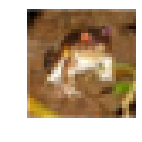

In [0]:
plt.figure(figsize=(2,2))
plot_image(reshape_instance(X_train[0]))
plt.show()

In [0]:
# Defining a function for generating mini-batches during training.

import numpy.random as rnd

def shuffle_batches(X, y, batch_size):
  rand_idx = rnd.permutation(len(X))
  n_batches = len(X) // batch_size
  for batch_idx in np.array_split(rand_idx, n_batches):
    yield X[batch_idx], y[batch_idx] 

#### Split the dataset into a training set and a test set. Train a deep denoising autoencoder on the full training set.

Since the data is already split into a training and a test set, I will start right away with training an autoencoder.

In [0]:
# Defining the model graph.

import tensorflow as tf
from functools import partial

def reset_graph(seed=42):
  tf.reset_default_graph()
  tf.set_random_seed(seed)
  rnd.seed(seed)

reset_graph()

n_inputs = 3 * (32 ** 2)
n_hidden1 = 3 * (16 ** 2)
n_hidden2 = 3 * (8 ** 2)
n_hidden3 = n_hidden1
n_outputs = n_inputs

learning_rate = 1e-3
dropout_rate = 0.3

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
training = tf.placeholder_with_default(False, shape=())

X_drop = tf.layers.dropout(X, rate=dropout_rate, training=training)

he_init = tf.contrib.layers.variance_scaling_initializer()

init_weights = lambda n1, n2, name: \
    tf.Variable(he_init([n1, n2]), dtype=tf.float32, name=name)
W1 = init_weights(n_inputs, n_hidden1, name='W1')
W2 = init_weights(n_hidden1, n_hidden2, name='W2')
W3 = init_weights(n_hidden2, n_hidden3, name='W3')
W4 = init_weights(n_hidden3, n_outputs, name='W4')

init_bias = lambda n, name: \
    tf.Variable(tf.zeros(n), dtype=tf.float32, name=name)
b1 = init_bias(n_hidden1, name='bias1')
b2 = init_bias(n_hidden2, name='bias2')
b3 = init_bias(n_hidden3, name='bias3')
b4 = init_bias(n_outputs, name='bias4')

hidden1 = tf.nn.elu(tf.matmul(X_drop, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
outputs = tf.nn.sigmoid(tf.matmul(hidden3, W4) + b4)

reconstruction_loss = tf.reduce_mean(tf.square(X - outputs))
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(reconstruction_loss)

saver = tf.train.Saver()
init = tf.global_variables_initializer()

In [0]:
# Train the model.

n_epochs = 50
batch_size = 150
model_path = 'cifar10_autoencoder'

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    n_batches = len(X_train) // batch_size
    i = 0
    for X_batch, _ in shuffle_batches(X_train, y_train, batch_size):
      i += 1
      print('\r{}%'.format(100 * i // n_batches), end='')
      sys.stdout.flush()
      sess.run(training_op, feed_dict={X: X_batch, training: True})
    loss_train = reconstruction_loss.eval(feed_dict={X: X_batch})
    if epoch % 5 == 0:
      print('\r{}'.format(epoch), 'Train MSE:', loss_train)
  saver.save(sess, model_path)
  loss_test = reconstruction_loss.eval(feed_dict={X: X_test})
  print('\rTest MSE:', loss_test)

0 Train MSE: 0.019156324
5 Train MSE: 0.011925949
10 Train MSE: 0.010401742
15 Train MSE: 0.009037251
20 Train MSE: 0.00828981
25 Train MSE: 0.008364517
30 Train MSE: 0.008173107
35 Train MSE: 0.008024467
40 Train MSE: 0.0070956266
45 Train MSE: 0.0076373117
Test MSE: 0.007620284


#### Check that the images are fairly well reconstructed, and visualize the low level features. Visualize the images that most activate each neuron in the coding layer.

In [0]:
# Plot some instances of the training set and their reconstruction. One per
# type of label.

examples = dict()

for i, x in enumerate(X_train):
  label = y_train[i]
  if label not in examples:
    examples[label] = x
    if len(examples) == 10:
      examples = list(examples.values())
      break

with tf.Session() as sess:
  init.run()
  saver.restore(sess, model_path)
  outputs_val = outputs.eval(feed_dict={X: examples})

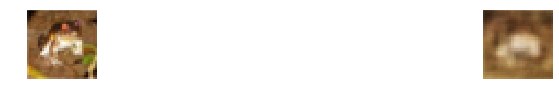

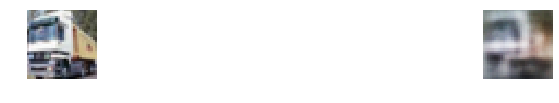

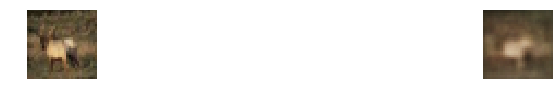

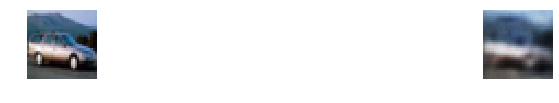

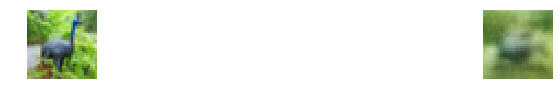

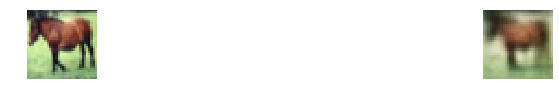

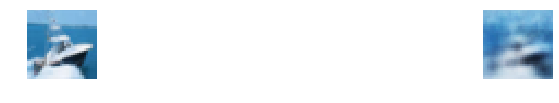

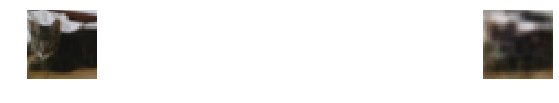

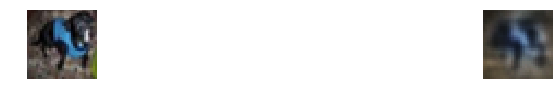

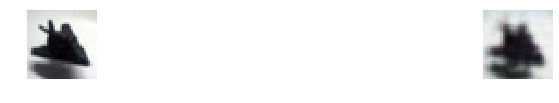

In [0]:
for i, x in enumerate(examples):
  plt.figure(figsize=(15, 15))
  plt.subplot(10, 2, (2 * i) + 1)
  plot_image(reshape_instance(x))
  plt.subplot(10, 2, (2 * i) + 2)
  plot_image(reshape_instance(outputs_val[i]))
plt.show()

In [0]:
# Getting the weights in the coding layers.

with tf.Session() as sess:
  init.run()
  weights1_val = W1.eval()
  weights2_val = W2.eval()

In [0]:
print(weights1_val.shape)
print(weights2_val.shape)

(3072, 768)
(768, 192)


In [0]:
# Defining a function for reshaping the weights layer.

def reshape_weights(weights, image_dim):
  pixels = [None for _ in range(image_dim ** 2)]
  for i in range(image_dim ** 2):
    pixels[i] = [weights[i + (j * (image_dim ** 2))] for j in range(3)]
  return np.array(pixels, dtype=np.float32)

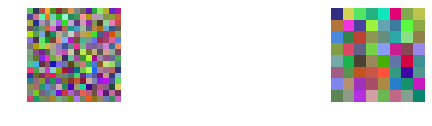

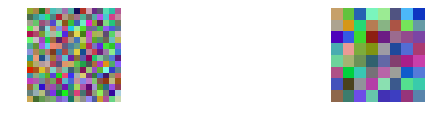

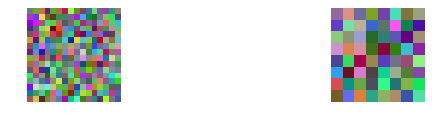

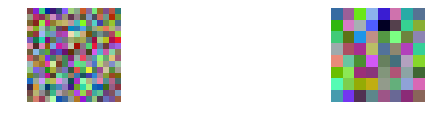

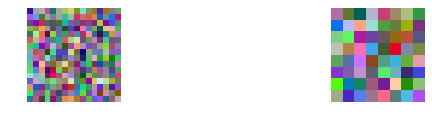

In [0]:
# Visualizing the coding layers. I use Scikit-Learn's MinMaxScaler to transform
# the weights to the range [0, 1].

from sklearn.preprocessing import MinMaxScaler

W1 = MinMaxScaler().fit_transform(weights1_val.T)
W2 = MinMaxScaler().fit_transform(weights2_val.T)
for i in range(5):
  plt.figure(figsize=(10, 10))
  plt.subplot(5, 2, (2 * i) + 1)
  plot_image(reshape_weights(W1[i], 16), shape=(16, 16, 3))
  plt.subplot(5, 2, (2 * i) + 2)
  plot_image(reshape_weights(W2[i], 8), shape=(8, 8, 3))
plt.show()

#### Build a classification deep neural network, reusing the lower layers of the autoencoder. Train it using only 10% of the training set. Can you get it to perform as well as the same classifier trained on the full training set?

In [0]:
# First going to create a classifier whose lower layers are the same shape
# as the autoencoder I trained above.

reset_graph()

n_inputs = 3 * (32 ** 2)
n_hidden1 = 3 * (16 ** 2)
n_hidden2 = 3 * (8 ** 2)
n_hidden3 = 150
n_outputs = 10

learning_rate = 1e-4
l2_reg = 0.0005

X = tf.placeholder(tf.float32, shape=(None, n_inputs))
y = tf.placeholder(tf.int32, shape=(None))

training = tf.placeholder_with_default(False, shape=())

he_init = tf.contrib.layers.variance_scaling_initializer()
dense = partial(tf.layers.dense, activation=tf.nn.elu,
                kernel_initializer=he_init)

he_init = tf.contrib.layers.variance_scaling_initializer()
regularizer = tf.contrib.layers.l2_regularizer(l2_reg)

init_weights = lambda n1, n2, name: \
    tf.Variable(he_init([n1, n2]), dtype=tf.float32, name=name)
W1 = init_weights(n_inputs, n_hidden1, name='W1')
W2 = init_weights(n_hidden1, n_hidden2, name='W2')
W3 = init_weights(n_hidden2, n_hidden3, name='W3')
W4 = init_weights(n_hidden3, n_outputs, name='W4')

init_bias = lambda n, name: \
    tf.Variable(tf.zeros(n), dtype=tf.float32, name=name)
b1 = init_bias(n_hidden1, name='bias1')
b2 = init_bias(n_hidden2, name='bias2')
b3 = init_bias(n_hidden3, name='bias3')
b4 = init_bias(n_outputs, name='bias4')

hidden1 = tf.nn.elu(tf.matmul(X, W1) + b1)
hidden2 = tf.nn.elu(tf.matmul(hidden1, W2) + b2)
hidden3 = tf.nn.elu(tf.matmul(hidden2, W3) + b3)
logits = tf.matmul(hidden3, W4) + b4

xentropy = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y,
                                                          logits=logits)
reg_loss = regularizer(W1) + regularizer(W2) + regularizer(W3) + \
    regularizer(W4)
loss = tf.reduce_mean(xentropy) + reg_loss
optimizer = tf.train.AdamOptimizer(learning_rate)
training_op = optimizer.minimize(loss)
pretrain_training_op = optimizer.minimize(loss, var_list=[W3, b3, W4, b4])

correct = tf.nn.in_top_k(logits, y, 1)
accuracy = tf.reduce_mean(tf.cast(correct, tf.float32))

pretrain_saver = tf.train.Saver([W1, W2, b1, b2])
init = tf.global_variables_initializer()

In [0]:
# Training the model without pretraining on the whole dataset.

n_epochs = 50
batch_size = 150

with tf.Session() as sess:
  init.run()
  for epoch in range(n_epochs):
    n_batches = len(X_train) // batch_size
    i = 0
    for X_batch, y_batch in shuffle_batches(X_train, y_train, batch_size):
      i += 1
      print('\r{}%'.format(100 * i // n_batches), end='')
      sys.stdout.flush()
      sess.run(training_op, feed_dict={X: X_batch, y: y_batch})
    if epoch % 5 == 0:
      loss_train = loss.eval(feed_dict={X: X_train, y: y_train})
      acc_train = accuracy.eval(feed_dict={X: X_train, y: y_train})
      print('\r{}'.format(epoch), 'Train Loss:', loss_train, 'Train Accuracy:',
            100 * acc_train)
  acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
  print('\rTest Accuracy:', 100 * acc_test)

0 Train Loss: 2.2848747 Train Accuracy: 39.743998646736145
5 Train Loss: 1.9611313 Train Accuracy: 48.980000615119934
10 Train Loss: 1.8068571 Train Accuracy: 53.67199778556824
15 Train Loss: 1.6686205 Train Accuracy: 57.50200152397156
20 Train Loss: 1.5706263 Train Accuracy: 60.27200222015381
25 Train Loss: 1.4803302 Train Accuracy: 63.26199769973755
30 Train Loss: 1.4532766 Train Accuracy: 63.14600110054016
35 Train Loss: 1.3512461 Train Accuracy: 66.85600280761719
40 Train Loss: 1.3468226 Train Accuracy: 66.58200025558472
45 Train Loss: 1.2468351 Train Accuracy: 70.0380027294159
Test Accuracy: 55.239999294281006


In [0]:
# Training the model with pretraining on 10% of the training dataset.
# It does not perform as well as training using the whole training set without
# pretraining, but this is expected given we're only using 10% of the training
# set for the supervised task.

n_epochs = 200
batch_size = 150

X_train_short = X_train[:len(X_train) // 10]
y_train_short = y_train[:len(y_train) // 10]

with tf.Session() as sess:
  init.run()
  pretrain_saver.restore(sess, model_path)
  for epoch in range(n_epochs):
    n_batches = len(X_train_short) // batch_size
    i = 0
    for X_batch, y_batch in shuffle_batches(X_train_short, y_train_short,
                                            batch_size):
      i += 1
      print('\r{}%'.format(100 * i // n_batches), end='')
      sys.stdout.flush()
      sess.run(pretrain_training_op, feed_dict={X: X_batch, y: y_batch})
    if epoch % 20 == 0:
      loss_train = loss.eval(feed_dict={X: X_train_short, y: y_train_short})
      acc_train = accuracy.eval(feed_dict={X: X_train_short, y: y_train_short})
      print('\r{}'.format(epoch), 'Train Loss:', loss_train, 'Train Accuracy:',
            100 * acc_train)
  acc_test = accuracy.eval(feed_dict={X: X_test, y: y_test})
  print('\rTest Accuracy:', 100 * acc_test)

0 Train Loss: 3.931398 Train Accuracy: 11.339999735355377
20 Train Loss: 3.0352888 Train Accuracy: 33.7799996137619
40 Train Loss: 2.8699465 Train Accuracy: 40.25999903678894
60 Train Loss: 2.7878394 Train Accuracy: 43.07999908924103
80 Train Loss: 2.737611 Train Accuracy: 44.760000705718994
100 Train Loss: 2.703654 Train Accuracy: 46.90000116825104
120 Train Loss: 2.672138 Train Accuracy: 48.339998722076416
140 Train Loss: 2.6493688 Train Accuracy: 48.62000048160553
160 Train Loss: 2.6204128 Train Accuracy: 49.73999857902527
180 Train Loss: 2.6003225 Train Accuracy: 50.8400022983551
Test Accuracy: 40.65000116825104


### 9. [_Semanting hashing_](http://www.cs.toronto.edu/~rsalakhu/papers/sdarticle.pdf) is a technique used for efficient _information retrieval_: a document (e.g. an iamges) is passed throug a system (typically a neural network) that outputs a low-dimensional binary vector (e.g. 30 bits). Indexing each document using its hash, it is possible to retrieve many documents similar to the particular document almonst instantly. Let's implement semantic hashing using a slightly tweaked stacked autoencoder.

#### Create a stacked autoencoder containng two hidden layers below the coding layer, and train it in the image dataset you used in the previous exercis. The coding layer should contain 30 neurons and use the logistic activation function to output values between 0 and 1. After training, to produce the hash of an image, you can simply run it through the autoencoder, take the output of the coding layer and round the output of each neuron to 0 or 1.

#### One trick proposed by Salakhutdinov and Hinton is to add Gaussian noise (with zero mean) to the inputs of the coding layer during training. In order to preserve a high signal-to-noise ration, the autoencoder will learn to feed large values to the coding layer. In turn, this means the logistic activation function of the coding layer will likely saturate at 0 or 1. As a result, rounding the codings to 0 or 1 won't distort the output as much.

#### Compute the hash of every image, and see if images with identical hashes look alike. Since the dataset is labeled, one way to measure the performance of the autoencoder is to see if images with the same hash are part of the same class. You can use the Gini purity (introduced in Chapter 6) of the sets of images with identical (or very similar hashes).

#### Try fine tuning the hyperparameters using cross-validation.

#### Note that with a labeled dataset, another approach is to train a convolutional neural network (CNN) for classiciation, then use the layer below the output layer to produce the hashes. See [Jimma Gua and Jianmin Li's 2015 paper](https://arxiv.org/pdf/1509.01354.pdf). See if it performs better.

### 10. Train a variational autoencoder on the image dataset used in the previous exercises and make it generate images. Alternatively, you can try to find an unlabeled dataset that you are interested in and see if you can generate new samples.

Look at this tutorial: https://www.tensorflow.org/beta/tutorials/generative/cvae for a convolutional variational autoencoder (CVAE).